# Pytorch Workflow

1. Data (prepare and load)
2. Build model
3. Fitting the model to data (train)
4. Making predictions and evaluating the model (inference)
5. Saving and loading the model
6. Putting it all together

In [1]:
import torch
from torch import nn #contains all building blocks for neural networks
import numpy as np
import matplotlib.pyplot as plt

### Linear representation

In [2]:
# Create known parameters:
weight = 0.7
bias = 0.3
# We wanna make a model that estimates these both numbers.
start = 0
end = 1.0
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias



In [3]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]


In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="predictions")

  plt.legend(prop={"size":14})


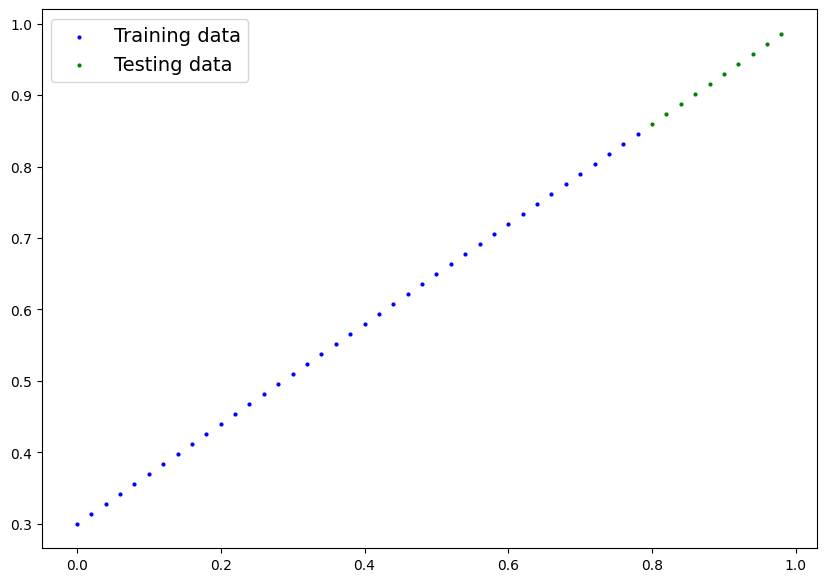

In [5]:
plot_predictions()

### Build Pytorch model

Gradient descent and backpropagation

In [6]:
# Linear regression class
from torch import nn

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    # Forward method to define the computation in the model
  def forward(self, x:torch.Tensor) -> torch.Tensor:   # x is the input data
      return self.weights * x + self.bias                 # linear regresion formula




### Pytorch model building essentials:

1. torch.nn: contains all building blocks for neural networks
2. torch.nn.parameter: what parameters should out model try and learn (often a pytorch layer from torch.nn will set these)
3. torch.nn.Module: The base class for all nn modules. If you subclass it, you should overwrite forward.
4. torch.optim: optimizers of pytorch.
5. def forward(): All nn.Module subclasses require to overwrite forward().
  

### Checking the contents of out pytorch model:

We're gonna see what's inside our module.

We can check out our model parameters using `.parameters()`.

In [7]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using ´torch.inference_mode()´

When we pass the data through our model, it will run through ´forward()´ method.



In [9]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [10]:
# Make predictions with mode():

with torch.inference_mode():
  y_preds = model_0(X_test)

# Inference_mode is preferred than no_grad
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

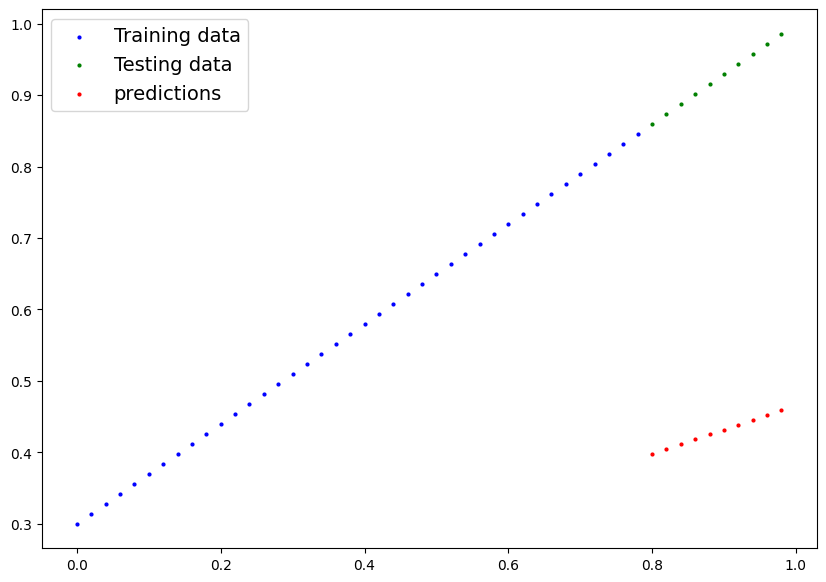

In [11]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some unknown parameters (may be random) to some known parameters. From a poor representation of the data to a better representation.

One way to measure how good the predictions are, we use a loss function.

In order to train:

- Loss function.
- Optimizer.

For pytorch, we need:
- A training loop
- A testing loop.

In [12]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
# Check models parameters: Values that the model sets itself.
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
# Setup a loss function
# Queremos minimizar el MAE:L1
loss_fn = nn.L1Loss()

# Setup an optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [15]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Building a training loop in PyTorch

A couple of things we need in a training loop:
0. Loop through the data.
1. Forward pass (this involves data moing through our model's forward functions) to make predictions on data
2. Calculate loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward (**backpropagation**) - move backwards through the network to calculate the gradients of each of the parameters of out model with respect to the loss
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve loss (**gradient descent**)

We want to predict, X_test, y_test

In [16]:
torch.manual_seed(42)

In [17]:
# An epoch is one loop through the data (hyperparameter)
epochs = 200

# Track different values so that we can compare our experiments to future experiments
epoch_count = []
loss_values = []
test_loss_values = []

### Training loop steps
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # Train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop... so we have to zero them in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # Turns off different setting in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # Turns off gradient tracking and a couple more things (we don't need to learn here so we turn off these things)
    # 1. Do the forward pass:
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(torch.tensor(loss).cpu().numpy())
    test_loss_values.append(torch.tensor(test_loss).cpu().numpy())
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

<ipython-input-17-1381d8dd0e32>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_values.append(torch.tensor(loss).cpu().numpy())
<ipython-input-17-1381d8dd0e32>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss_values.append(torch.tensor(test_loss).cpu().numpy())


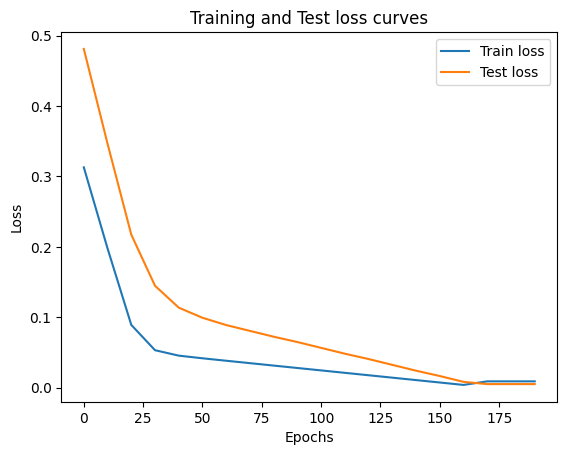

In [18]:
# Plot the loss curves
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

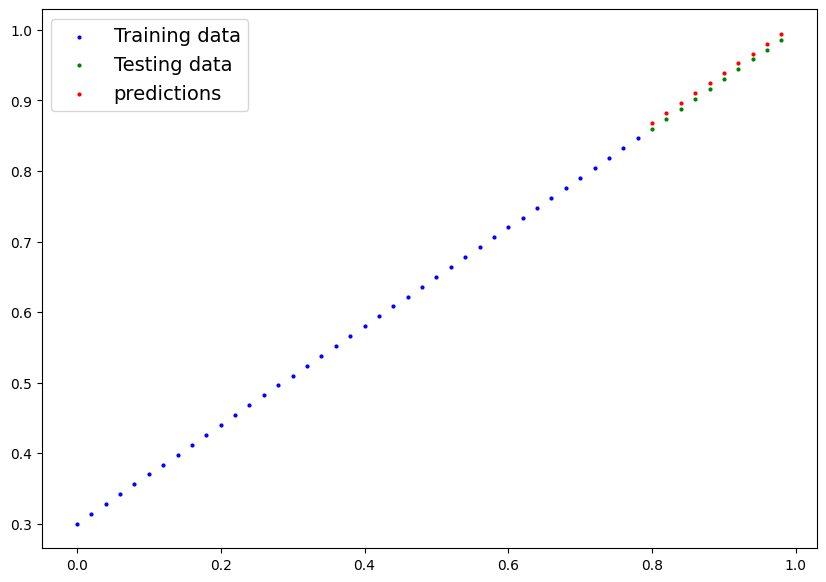

In [21]:
plot_predictions(predictions=y_preds_new);

# Saving a model in PyTorch (specially after training a large model)

There are three main methods for saving and loading methods in pytorch.

1. torch.save() - allows you to save a pytorch object in python pickle format
2. torch.load() - Load a saved pytorch object
3. torch.nn.Module.load_state:dict() - load a model's saved state dictionary

In [22]:
# Save out PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [23]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Nov 13 15:41 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved out models state_dict rather than the entire model, we'll create a new instance of out model class and load the saved state_dict into that.

In [24]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
# To load in a saved state_dict we have to initiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [26]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [27]:
# Make some predictions with out loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [28]:
# We compare with the original model's preds
y_preds = model_0(X_test)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together.

Let's go back through the steps above and see all in one place

In [29]:
import torch
from torch import nn
import matplotlib.pyplot as plt

#Check version
torch.__version__

'2.1.0+cu118'

Create device agnostic code.

If we got access to gpu, our code will use ir for potentially faster computing. If no gpu is available, the code will default to using cpu.

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [31]:
!nvidia-smi

Mon Nov 13 15:41:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 6.1 Data

In [32]:
# Create some data using the linear regression formula using y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1.0
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [33]:
# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

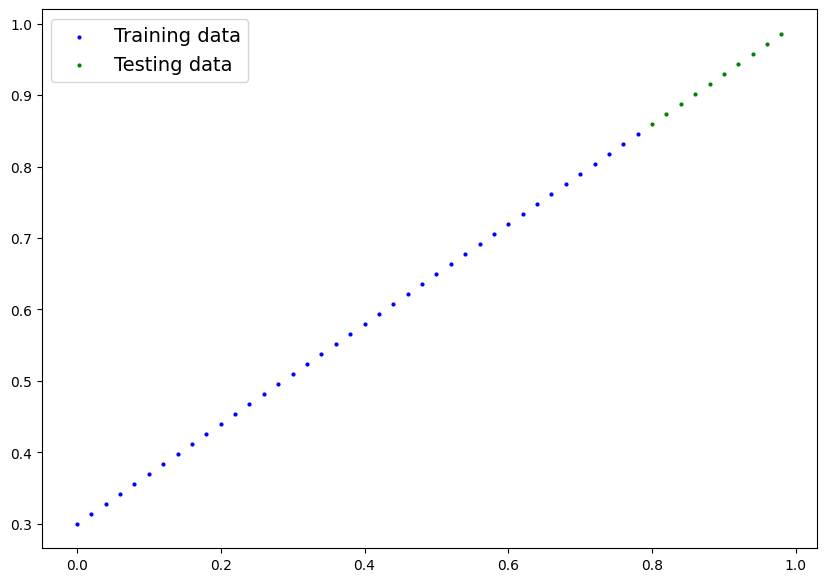

In [34]:
# Plot the data
# Note: plot_predictions()
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch linear model

In [35]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() (because our data is linear) for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [36]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [37]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training:

- Loss function.
- Optimizer.
- Training loop.
- Testing loop.

In [38]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [39]:
# Write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (agnostic code for data also)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_pred = model_1(X_test)
    # Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [40]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

## 6.4 Making and evaluating predictions

In [41]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

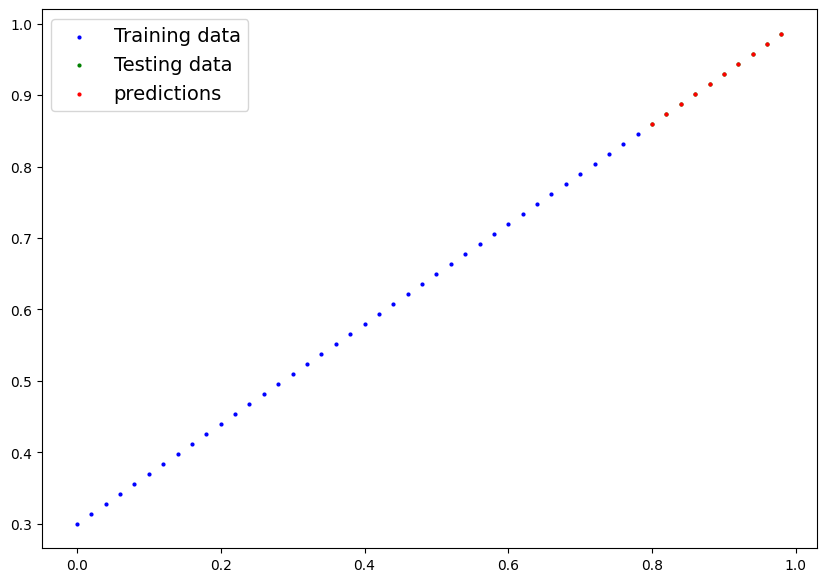

In [44]:
# Check out our model predictions visually
plot_predictions(predictions=y_preds.cpu())

## 6.5 Saving and loading a trained model

In [47]:
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [48]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [50]:
# Load a PyTorch

# Create a new instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model state_dict()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to the device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [51]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [52]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [53]:
# Evaluate the loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Exercises and extra-curriculum